In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [271]:
# Turn off while experimenting
warnings.filterwarnings('ignore')

In [272]:
# Ensure reproducibility
REP = 1
np.random.seed(REP)

## Group 7
### 012205927 - Ana Terović
### 012206591 - Fani Sentinella-Jerbić
### 012228451 - Jasper De Landsheere

Github: https://github.com/anaterovic/TFRTML

### Import data

In [273]:
df = pd.read_csv("diterpene_shuf.csv")
df

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,a45c
0,2,4,8,6,v1493,t,139.2,q,33.2,d,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,2,4,8,6,v1255,d,144.0,q,66.7,d,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,2,4,8,6,v2194,d,30.7,t,26.8,t,...,16.7,t,35.4,q,65.8,s,42.4,d,139.8,54c
3,3,4,9,4,v2021,t,37.2,t,17.4,q,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,3,4,9,4,v1051,q,12.2,d,154.6,t,...,49.5,t,38.8,t,71.4,s,36.8,s,46.2,3c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2,3,8,7,v501,q,18.8,t,32.5,d,...,172.1,q,62.3,d,36.1,t,27.0,s,38.8,54c
1198,2,4,8,6,v785,q,60.6,t,29.3,t,...,59.1,s,39.7,d,142.6,q,18.8,d,36.2,54c
1199,2,4,8,6,v2174,q,166.1,q,62.5,s,...,44.5,d,55.6,d,147.3,q,107.0,t,47.1,52c
1200,2,4,8,6,v1332,t,36.5,d,46.4,t,...,17.3,t,120.4,q,17.8,d,144.4,t,35.9,54c


# Data exploration and preprocessing

### Short explaination of the dataset

*Each diterpene is described with NMR spectroscopy. In this dataset each spectrum is described by the frequency and multiplicity of all peaks. The skeleton of every diterpene contains 20 carbon atoms. So, for every carbon atom we have its frequency and multiplicity. For multiplicity we have s(singulet), d(doublet), t(triplet), q(quartet). If an atom of carbon is connected to no hydrogen atoms its singulet, if its connected to one hydrogen its doublet, two hydrogens triplet and three hydrogens connected to one carbon atom is quartet.*

- Columns a0 to a3 represent how many times s, d, t, q values have accured.
- Column a4 is sample id.
- Columns a5 to a44 tells us the frequency and multiplicity of each carbon atom.
- Column a45c represents the classification class.

Example, for sample 0:
In a5 to a44, 's' value has occured 2 times, 'd' 4 times, 't' 8 times and 'q' 6 times. 'v1493' is its ID value. Then for the next 40 columns we have for each of the 20 carbon atoms its multiplicity (s,d,t,q) and frequency. Finally, in a45c we can see that sample 0 belongs to class 52c. 

--------------------
### Rename according exercise

In [274]:
# Rename column "a45c" to "Class", "a4" to "ID"
df = df.rename(columns={"a45c": "Class", "a4": "ID"})
# Inspect
df.head()

,a0,a1,a2,a3,ID,a5,a6,a7,a8,a9,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,Class
0,2,4,8,6,v1493,t,139.2,q,33.2,d,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,2,4,8,6,v1255,d,144.0,q,66.7,d,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,2,4,8,6,v2194,d,30.7,t,26.8,t,...,16.7,t,35.4,q,65.8,s,42.4,d,139.8,54c
3,3,4,9,4,v2021,t,37.2,t,17.4,q,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,3,4,9,4,v1051,q,12.2,d,154.6,t,...,49.5,t,38.8,t,71.4,s,36.8,s,46.2,3c


------------------------
### Preprocessing

As decribed in the official paper, some preprocessing can help get better results. For this purpose we will create another dataset df_reduced which will have the reduced multiplicities.

We will use this dataset only when explicitly said.

In [275]:
# Create a copy
df_reduced = df.copy()

In [276]:
# For each sample of the dataset
def preprocessing(df_reduced):
    col_names = df_reduced.columns
    for i in tqdm(range(len(df_reduced))):
        
        for j in range (len(col_names)):

            if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 64.5 and df_reduced[col_names[j+1]][i] <= 95:
                df_reduced[col_names[j]][i] = 'd'

            if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 96 and df_reduced[col_names[j+1]][i] <= 114:
                df_reduced[col_names[j]][i] = 't'

            if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 115 and df_reduced[col_names[j+1]][i] <= 165:
                df_reduced[col_names[j]][i] = 'd'

            if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 165 and df_reduced[col_names[j+1]][i] <= 188:
                df_reduced[col_names[j]][i] = 'q'

            if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 188 and df_reduced[col_names[j+1]][i] <= math.inf:
                df_reduced[col_names[j]][i] = 't'


            if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 64.5 and df_reduced[col_names[j+1]][i] <= 95:
                df_reduced[col_names[j]][i] = 't'

            if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 105 and df_reduced[col_names[j+1]][i] <= 180:
                df_reduced[col_names[j]][i] = 't'

            if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 96 and df_reduced[col_names[j+1]][i] <= 104:
                df_reduced[col_names[j]][i] = 'q'

            if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 180 and df_reduced[col_names[j+1]][i] <= math.inf:
                df_reduced[col_names[j]][i] = 'q'


            if df_reduced[col_names[j]][i] == 't' and df_reduced[col_names[j+1]][i] >= 59 and df_reduced[col_names[j+1]][i] <= 90:
                df_reduced[col_names[j]][i] = 'q'

            if df_reduced[col_names[j]][i] == 't' and df_reduced[col_names[j+1]][i] >= 90 and df_reduced[col_names[j+1]][i] <= math.inf:
                df_reduced[col_names[j]][i] = 'q'
    return df_reduced

In [277]:
df_reduced = preprocessing(df_reduced)

100%|██████████| 1202/1202 [00:05<00:00, 228.35it/s]


In [278]:
df_reduced.head()

,a0,a1,a2,a3,ID,a5,a6,a7,a8,a9,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,Class
0,2,4,8,6,v1493,q,139.2,q,33.2,d,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,2,4,8,6,v1255,q,144.0,q,66.7,d,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,2,4,8,6,v2194,d,30.7,t,26.8,t,...,16.7,t,35.4,q,65.8,s,42.4,q,139.8,54c
3,3,4,9,4,v2021,t,37.2,t,17.4,q,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,3,4,9,4,v1051,q,12.2,q,154.6,t,...,49.5,t,38.8,q,71.4,s,36.8,s,46.2,3c


-----------------------
# Classification

We preliminarily try 3 different algorithms to gain the initial intuition of our problem. 

We define a function for faster evaluation of different models. At this stage we are satisfied with hold out for evaluation.

In [279]:
def evaluate(clfs, X, y, plot=True):
    results = []
    
    for clf in clfs:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
        # Fit the model
        clf.fit(X_train, y_train)
    
        # Make predictions
        y_pred = clf.predict(X_test)
    
        # Get name of the classifier
        name = type(clf).__name__
        
        # Calculate different scores
        res = {
            'Algorithm': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1 macro': f1_score(y_test, y_pred, average='macro'),
            'F1 micro': f1_score(y_test, y_pred, average='micro')
        }
        
        if plot:
            ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,  cmap='rocket_r')
        
        results.append(res)
        
    return pd.DataFrame(results)

clfs_to_try = [LogisticRegression(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier()]

----------------

## Multiplicity assumption

We know our diterpenes have 20 carbon atoms. The multiplicity of a carbon atom seems to be a very important information. We suspect the amount of carbons with a specific multiplicity may already be a big hint for models to discriminate between different diterpenes.

In [280]:
# Consider only multiplicity counts
df_simple = df[['a0', 'a1', 'a2', 'a3', 'Class']]
df_simple.head()

,a0,a1,a2,a3,Class
0,2,4,8,6,52c
1,2,4,8,6,54c
2,2,4,8,6,54c
3,3,4,9,4,3c
4,3,4,9,4,3c


In [281]:
# Rename columns for better readability
df_simple = df_simple.rename(columns={'a0':'s_cnt', 'a1':'d_cnt', 'a2':'t_cnt', 'a3':'q_cnt'})

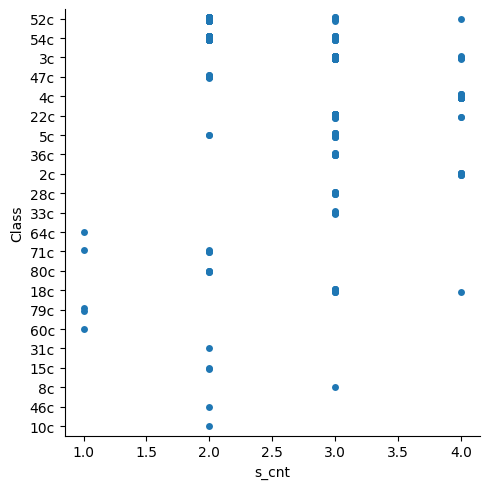

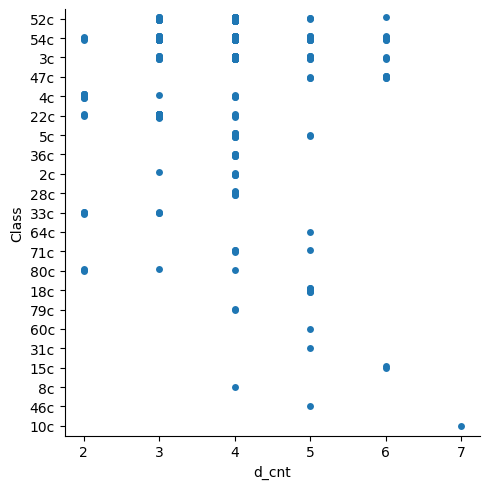

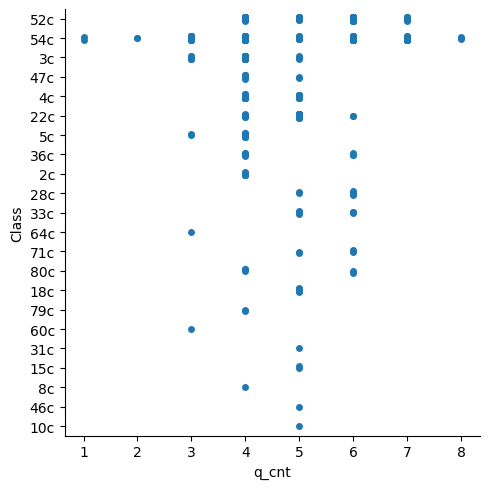

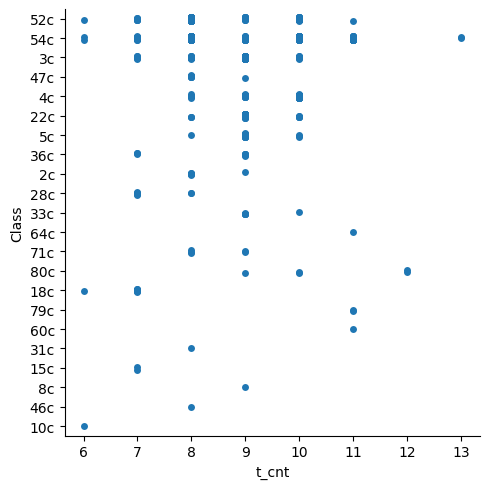

In [282]:
# Plot each multiplicity per class
sns.catplot(data=df_simple, y="Class", x='s_cnt')
sns.catplot(data=df_simple, y="Class", x='d_cnt')
sns.catplot(data=df_simple, y="Class", x='q_cnt')
sns.catplot(data=df_simple, y="Class", x='t_cnt')

We can see there could be some regularities in this, for example diterpene 52c (our majority class) never has 1 singulet, it always has 2, 3 or 4. This seems promising. Let's check.

In [283]:
X = df_simple[['s_cnt', 'd_cnt', 't_cnt', 'q_cnt']]
y = df_simple['Class']
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.717842,0.311467,0.717842
1,KNeighborsClassifier,0.784232,0.356643,0.784232
2,DecisionTreeClassifier,0.784232,0.404913,0.784232


Indeed, it seems like the information about multiplicity brings good discriminatory value to our models.

## Insignificance of order assumption

Although the multiplicity already brings a lot of information, we want to also somehow incorporate the frequency information into our models.

In [284]:
# Get the rest of features
df_rest = df.drop(columns=['a0', 'a1', 'a2', 'a3','ID', 'Class'])
df_rest.head()

,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,...,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44
0,t,139.2,q,33.2,d,30.7,d,49.6,t,38.6,...,d,134.5,t,24.2,q,14.4,t,42.2,t,18.6
1,d,144.0,q,66.7,d,46.2,t,32.7,q,19.1,...,t,22.4,s,37.7,q,19.7,q,16.5,t,26.6
2,d,30.7,t,26.8,t,41.2,t,139.3,q,19.8,...,t,16.7,t,35.4,q,65.8,s,42.4,d,139.8
3,t,37.2,t,17.4,q,16.7,s,58.1,t,41.6,...,s,33.5,d,44.9,d,56.6,q,20.8,t,36.5
4,q,12.2,d,154.6,t,18.7,t,37.1,t,79.1,...,d,49.5,t,38.8,t,71.4,s,36.8,s,46.2


As previously mentioned, we know we have multiple multiplicity-frequency pairs for each diterpene structure. We will assume the order of the pairs is not important, and sum up frequencies for each multiplicity as new features for our models.

In [285]:
t = []
q = []
s = []
d = []
cols = df_rest.columns.values

# Consider each structure individually
for index, row in df_rest.iterrows():
    # Add up frequencies for each multiplicity
    tval = qval = sval = dval = 0
    for i in range(1, len(cols), 2):
        mul = row[cols[i-1]]
        freq = row[cols[i]]
        if mul == 't':
            tval = tval + freq
        elif mul == 'q':
            qval = qval + freq
        elif mul == 's':
            sval = sval + freq
        elif mul == 'd':
            dval = dval + freq
    t.append(tval)
    q.append(qval)
    s.append(sval)
    d.append(dval)
    
X['t_freq'] = t
X['q_freq'] = q
X['s_freq'] = s
X['d_freq'] = d

In [286]:
X.head()

,s_cnt,d_cnt,t_cnt,q_cnt,t_freq,q_freq,s_freq,d_freq
0,2,4,8,6,368.0,323.3,69.8,266.1
1,2,4,8,6,415.2,199.1,75.7,371.1
2,2,4,8,6,347.0,463.2,80.8,252.7
3,3,4,9,4,473.9,139.1,131.7,234.0
4,3,4,9,4,409.9,203.4,123.0,323.1


In [287]:
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.688797,0.345219,0.688797
1,KNeighborsClassifier,0.751037,0.515417,0.751037
2,DecisionTreeClassifier,0.892116,0.696887,0.892116


In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.726141,0.326514,0.726141


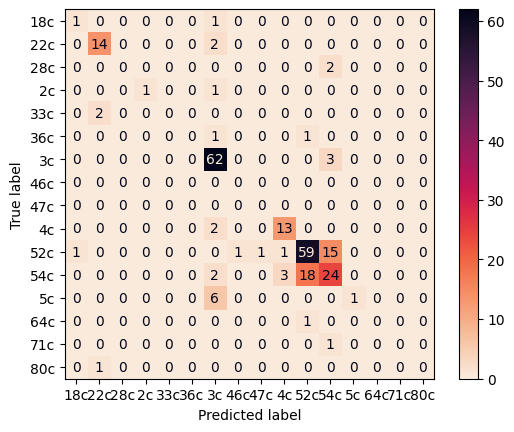

In [289]:
# Do a grid search
clf = LogisticRegression(random_state=REP)
grid_values = {'penalty': ['l2'], 
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver':['lbfgs'], 
               'max_iter':[100,1000,2500]
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([LogisticRegression(**grid_clf_acc.best_params_)], X, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'

,Algorithm,Accuracy,F1 macro,F1 micro
0,DecisionTreeClassifier,0.883817,0.687273,0.883817


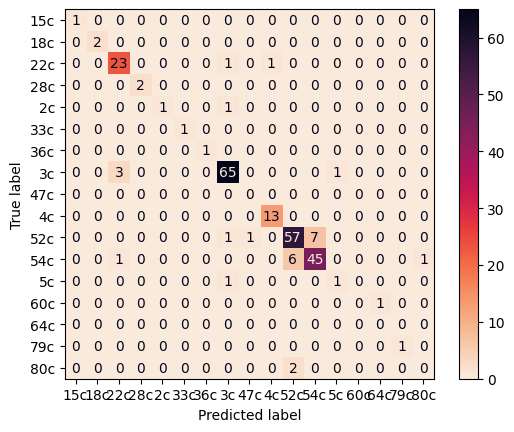

In [290]:
# Do a grid search
clf = DecisionTreeClassifier(random_state=REP)
grid_values = {'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 6, 7, 8, 9, 10, None],
               'max_features': ['auto', 'sqrt', 'log2']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([DecisionTreeClassifier(**grid_clf_acc.best_params_)], X, y)

,Algorithm,Accuracy,F1 macro,F1 micro
0,KNeighborsClassifier,0.858921,0.639613,0.858921


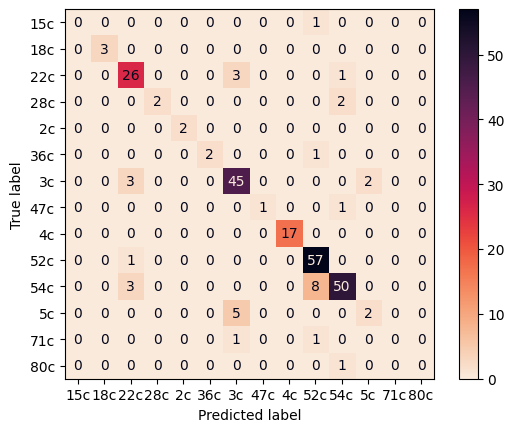

In [291]:
# Do a grid search
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[6,8,10,12,14,16,18,20],
               'leaf_size':list(range(1,50,5)),
               "metric":["euclidean", "manhattan", "chebyshev"],
               'weights':['uniform', 'distance'],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([KNeighborsClassifier(**grid_clf_acc.best_params_)], X, y)

-----------------
## New features

Now we will add mean, std, min and max of frequencies as new features of our model.

In [292]:
X = df_simple[['s_cnt', 'd_cnt', 't_cnt', 'q_cnt']]

In [293]:
def add_new_features(df_rest, X):

    #calculate new features
    t_sum = []
    q_sum = []
    s_sum = []
    d_sum = []
    t_mean = []
    q_mean = []
    s_mean = []
    d_mean = []
    t_std = []
    q_std = []
    s_std = []
    d_std = []
    t_min = []
    q_min = []
    s_min = []
    d_min = []
    t_max = []
    q_max = []
    s_max = []
    d_max = []
    cols = df_rest.columns.values

    # Consider each structure individually
    for index, row in df_rest.iterrows():
        tvals = []
        qvals = []
        svals = []
        dvals = []
        # Gather up frequencies for each multiplicity
        for i in range(1, len(cols), 2):
            mul = row[cols[i-1]]
            freq = row[cols[i]]
            if mul == 't':
                tvals.append(freq)
            elif mul == 'q':
                qvals.append(freq)
            elif mul == 's':
                svals.append(freq)
            elif mul == 'd':
                dvals.append(freq)

        if len(tvals)==0: tvals.append(0)
        if len(qvals)==0: qvals.append(0)
        if len(svals)==0: svals.append(0)
        if len(dvals)==0: dvals.append(0)
                
        t_sum.append(sum(tvals))
        q_sum.append(sum(qvals))
        s_sum.append(sum(svals))
        d_sum.append(sum(dvals))
        
        t_mean.append(np.mean(tvals))
        q_mean.append(np.mean(qvals))
        s_mean.append(np.mean(svals))
        d_mean.append(np.mean(dvals))
        
        t_std.append(np.std(tvals))
        q_std.append(np.std(qvals))
        s_std.append(np.std(svals))
        d_std.append(np.std(dvals))
        
        t_min.append(np.min(tvals))
        q_min.append(np.min(qvals))
        s_min.append(np.min(svals))
        d_min.append(np.min(dvals))
        
        t_max.append(np.max(tvals))
        q_max.append(np.max(qvals))
        s_max.append(np.max(svals))
        d_max.append(np.max(dvals))


    #add new features
    X['t_freq_sum'] = t_sum
    X['q_freq_sum'] = q_sum
    X['s_freq_sum'] = s_sum
    X['d_freq_sum'] = d_sum
    X['t_freq_mean'] = t_mean
    X['q_freq_mean'] = q_mean
    X['s_freq_mean'] = s_mean
    X['d_freq_mean'] = d_mean
    X['t_freq_std'] = t_std
    X['q_freq_std'] = q_std
    X['s_freq_std'] = s_std
    X['d_freq_std'] = d_std
    X['t_freq_min'] = t_min
    X['q_freq_min'] = q_min
    X['s_freq_min'] = s_min
    X['d_freq_min'] = d_min
    X['t_freq_max'] = t_max
    X['q_freq_max'] = q_max
    X['s_freq_max'] = s_max
    X['d_freq_max'] = d_max

    return X

In [294]:
X = add_new_features(df_rest, X)

In [295]:
X

,s_cnt,d_cnt,t_cnt,q_cnt,t_freq_sum,q_freq_sum,s_freq_sum,d_freq_sum,t_freq_mean,q_freq_mean,...,s_freq_std,d_freq_std,t_freq_min,q_freq_min,s_freq_min,d_freq_min,t_freq_max,q_freq_max,s_freq_max,d_freq_max
0,2,4,8,6,368.0,323.3,69.8,266.1,46.000000,53.883333,...,2.100000,40.069588,18.6,14.4,32.8,30.7,139.2,173.5,37.0,134.5
1,2,4,8,6,415.2,199.1,75.7,371.1,51.900000,33.183333,...,0.150000,49.381594,17.7,16.5,37.7,40.7,122.7,66.7,38.0,144.0
2,2,4,8,6,347.0,463.2,80.8,252.7,43.375000,77.200000,...,2.000000,44.588809,16.7,15.6,38.4,30.7,139.3,173.3,42.4,139.8
3,3,4,9,4,473.9,139.1,131.7,234.0,52.655556,34.775000,...,10.396153,12.486993,17.4,16.7,33.5,44.9,212.4,68.9,58.1,78.8
4,3,4,9,4,409.9,203.4,123.0,323.1,45.544444,50.850000,...,3.902136,45.026902,18.7,12.2,36.8,39.8,79.1,109.7,46.2,154.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2,3,8,7,609.8,321.9,78.8,225.1,76.225000,45.985714,...,0.600000,48.296400,27.0,15.7,38.8,36.1,200.1,172.1,40.0,143.1
1198,2,4,8,6,485.3,254.8,88.0,370.3,60.662500,42.466667,...,4.300000,50.837111,19.1,16.4,39.7,36.2,127.8,74.2,48.3,143.9
1199,2,4,8,6,401.5,407.4,75.3,416.5,50.187500,67.900000,...,3.050000,48.252947,22.6,15.3,34.6,55.6,117.3,166.1,40.7,157.2
1200,2,4,8,6,335.3,153.5,76.4,257.5,41.912500,25.583333,...,0.100000,46.549241,17.3,15.7,38.1,30.6,120.4,62.8,38.3,144.4


In [296]:
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.842324,0.652606,0.842324
1,KNeighborsClassifier,0.780083,0.535114,0.780083
2,DecisionTreeClassifier,0.883817,0.706512,0.883817


In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'

,Algorithm,Accuracy,F1 macro,F1 micro
0,DecisionTreeClassifier,0.838174,0.587306,0.838174


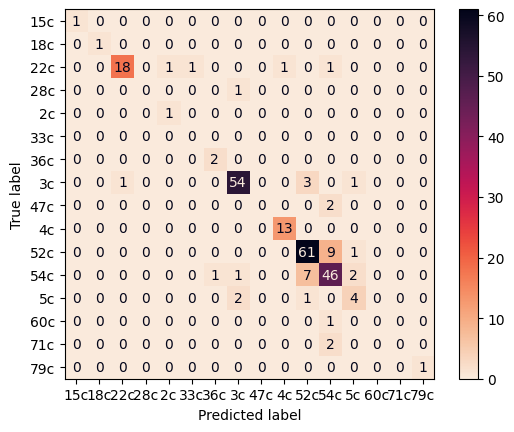

In [298]:
# Do a grid search
clf = DecisionTreeClassifier(random_state=REP)
grid_values = {'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 6, 7, 8, 9, 10, None],
               'max_features': ['auto', 'sqrt', 'log2']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([DecisionTreeClassifier(**grid_clf_acc.best_params_)], X, y)

,Algorithm,Accuracy,F1 macro,F1 micro
0,KNeighborsClassifier,0.896266,0.671902,0.896266


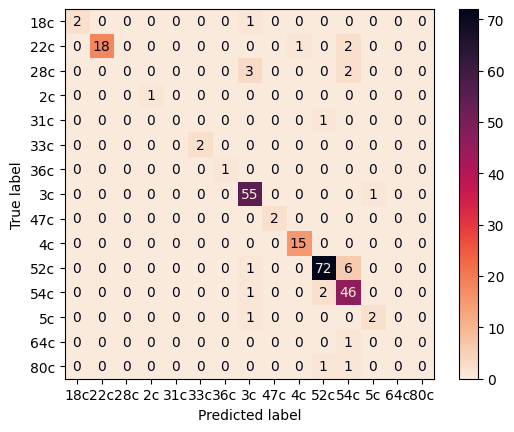

In [299]:
# Do a grid search
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[6,8,10,12,14,16,18,20],
               'leaf_size':list(range(1,50,5)),
               "metric":["euclidean", "manhattan", "chebyshev"],
               'weights':['uniform', 'distance'],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([KNeighborsClassifier(**grid_clf_acc.best_params_)], X, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.896266,0.710907,0.896266


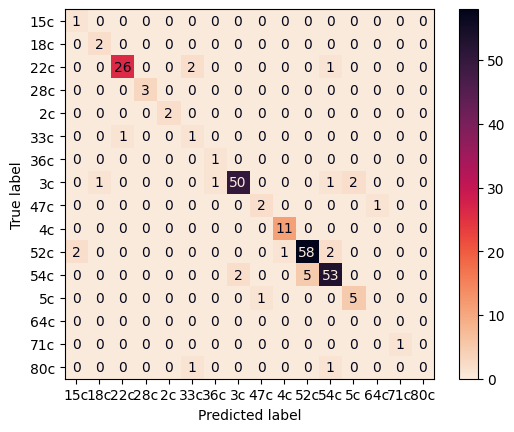

In [300]:
# Do a grid search
clf = LogisticRegression(random_state=REP)
grid_values = {'penalty': ['l2'], 
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver':['lbfgs'], 
               'max_iter':[100,1000,2500]
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([LogisticRegression(**grid_clf_acc.best_params_)], X, y)

In [301]:
score = cross_val_score(LogisticRegression(**grid_clf_acc.best_params_), X=X, y=y)
print("{:.4} +/- {:.4}".format(np.mean(score), np.std(score)))

0.9101 +/- 0.008568


--------------------------

### Applying the preprocessed data
Let's try to do the same as above, ignoring the order of variables, but applying preprocessed data.

In [302]:
# Consider only multiplicity counts
df_simple = df_reduced[['a0', 'a1', 'a2', 'a3', 'Class']]
df_simple.head()

,a0,a1,a2,a3,Class
0,2,4,8,6,52c
1,2,4,8,6,54c
2,2,4,8,6,54c
3,3,4,9,4,3c
4,3,4,9,4,3c


In [303]:
# Rename columns for better readability
df_simple = df_simple.rename(columns={'a0':'s_cnt', 'a1':'d_cnt', 'a2':'t_cnt', 'a3':'q_cnt'})

In [304]:
X_reduced = df_simple[['s_cnt', 'd_cnt', 't_cnt', 'q_cnt']]
y = df_simple['Class']

In [305]:
# Get the rest of features
df_rest = df_reduced.drop(columns=['a0', 'a1', 'a2', 'a3','ID', 'Class'])
df_rest.head()

,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,...,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44
0,q,139.2,q,33.2,d,30.7,d,49.6,t,38.6,...,q,134.5,t,24.2,q,14.4,t,42.2,t,18.6
1,q,144.0,q,66.7,d,46.2,t,32.7,q,19.1,...,t,22.4,s,37.7,q,19.7,q,16.5,t,26.6
2,d,30.7,t,26.8,t,41.2,q,139.3,q,19.8,...,t,16.7,t,35.4,q,65.8,s,42.4,q,139.8
3,t,37.2,t,17.4,q,16.7,s,58.1,t,41.6,...,s,33.5,d,44.9,d,56.6,q,20.8,t,36.5
4,q,12.2,q,154.6,t,18.7,t,37.1,q,79.1,...,d,49.5,t,38.8,q,71.4,s,36.8,s,46.2


In [306]:
X_reduced = add_new_features(df_rest, X_reduced)

In [307]:
X_reduced

,s_cnt,d_cnt,t_cnt,q_cnt,t_freq_sum,q_freq_sum,s_freq_sum,d_freq_sum,t_freq_mean,q_freq_mean,...,s_freq_std,d_freq_std,t_freq_min,q_freq_min,s_freq_min,d_freq_min,t_freq_max,q_freq_max,s_freq_max,d_freq_max
0,2,4,8,6,228.8,597.0,69.8,131.6,32.685714,74.625000,...,2.100000,9.336071,18.6,14.4,32.8,30.7,42.2,173.5,37.0,51.3
1,2,4,8,6,172.0,726.5,75.7,86.9,28.666667,72.650000,...,0.150000,2.750000,17.7,16.5,37.7,40.7,36.6,144.0,38.0,46.2
2,2,4,8,6,207.7,742.3,80.8,112.9,29.671429,92.787500,...,2.000000,6.432383,16.7,15.6,38.4,30.7,41.2,173.3,42.4,46.2
3,3,4,9,4,261.5,430.3,131.7,155.2,32.687500,71.716667,...,10.396153,4.974826,17.4,16.7,33.5,44.9,45.1,212.4,58.1,56.6
4,3,4,9,4,184.7,662.4,123.0,89.3,30.783333,73.600000,...,3.902136,4.850000,18.7,12.2,36.8,39.8,43.3,154.6,46.2,49.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2,3,8,7,166.2,908.6,78.8,82.0,33.240000,82.600000,...,0.600000,4.900000,27.0,15.7,38.8,36.1,35.9,200.1,40.0,45.9
1198,2,4,8,6,154.2,872.4,88.0,83.8,30.840000,79.309091,...,4.300000,5.700000,19.1,16.4,39.7,36.2,39.6,143.9,48.3,47.6
1199,2,4,8,6,209.9,903.5,75.3,112.0,34.983333,90.350000,...,3.050000,0.400000,22.6,15.3,34.6,55.6,47.1,166.1,40.7,56.4
1200,2,4,8,6,214.9,418.3,76.4,113.1,30.700000,52.287500,...,0.100000,6.548791,17.3,15.7,38.1,30.6,36.5,144.4,38.3,46.4


In [308]:
evaluate(clfs_to_try, X_reduced, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.709544,0.285150,0.709544
1,KNeighborsClassifier,0.688797,0.255497,0.688797
2,DecisionTreeClassifier,0.904564,0.597523,0.904564


In [309]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'

,Algorithm,Accuracy,F1 macro,F1 micro
0,DecisionTreeClassifier,0.875519,0.523595,0.875519


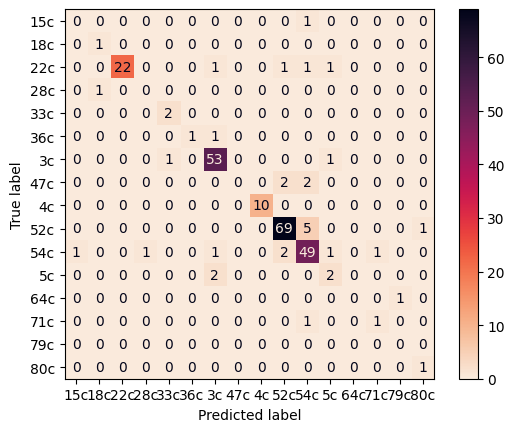

In [310]:
# Do a grid search
clf = DecisionTreeClassifier(random_state=REP)
grid_values = {'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 6, 7, 8, 9, 10, None],
               'max_features': ['auto', 'sqrt', 'log2']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([DecisionTreeClassifier(**grid_clf_acc.best_params_)], X_reduced, y)

,Algorithm,Accuracy,F1 macro,F1 micro
0,KNeighborsClassifier,0.850622,0.610361,0.850622


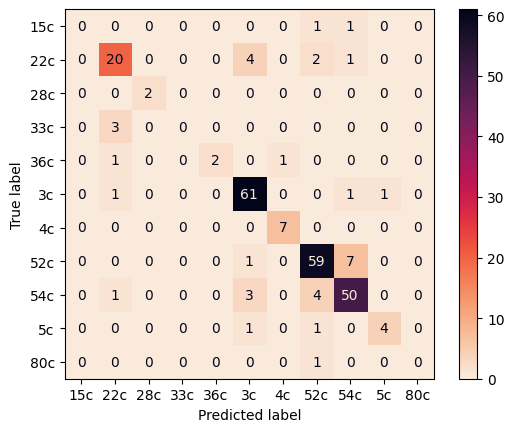

In [311]:
# Do a grid search
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[6,8,10,12,14,16,18,20],
               'leaf_size':list(range(1,50,5)),
               "metric":["euclidean", "manhattan", "chebyshev"],
               'weights':['uniform', 'distance'],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([KNeighborsClassifier(**grid_clf_acc.best_params_)], X_reduced, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.896266,0.616444,0.896266


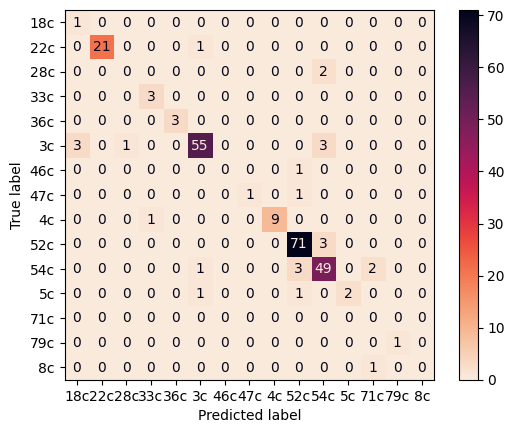

In [312]:
# Do a grid search
clf = LogisticRegression(random_state=REP)
grid_values = {'penalty': ['l2'], 
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver':['lbfgs'], 
               'max_iter':[100,1000,2500]
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([LogisticRegression(**grid_clf_acc.best_params_)], X_reduced, y)

In [313]:
score = cross_val_score(LogisticRegression(**grid_clf_acc.best_params_), X=X_reduced, y=y)
print("{:.4} +/- {:.4}".format(np.mean(score), np.std(score)))

0.8943 +/- 0.02257


Preprocessed data didn't give better results than the original data in this case.

-----------------------

## SVM
For our final method we will implement SVM with a RBF kernel using the preprocessed data.

In [314]:
# Compute RBF kernel
def rbf_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

# Compute Gram matrix
def gram_matrix(X, gamma):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            kernel_sum = 0
            for element_i in range(n_features):
                for element_j in range(n_features):
                    # If the elements are the same and they are strings
                    if X[i][element_i] == X[j][element_j] and type(X[i][element_i]) == str:
                        kernel_sum += rbf_kernel(X[i][element_i + 1], X[j][element_j +1 ], gamma) 
            K[i, j] = kernel_sum
            K[j, i] = kernel_sum
    return K

def test_gram_matrix(X_train, X_test, gamma):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    n_features=X_test.shape[1]
    K = np.zeros((n_test, n_train))
    for i in range(n_test):
        for j in range(n_train):
            kernel_sum = 0
            for element_i in range(n_features):
                for element_j in range(n_features):
                    if X_test[i][element_i] == X_train[j][element_j] and type(X_test[i][element_i]) == str:
                        kernel_sum += rbf_kernel(X_test[i][element_i + 1], X_train[j][element_j + 1], gamma)
            K[i, j] = kernel_sum
    return K


In [315]:
# Split data into training and test sets
X = df_reduced.drop(["a0", "a1", "a2", "a3", "ID", "Class"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=REP)

# Compute Gram matrix for training set
gamma = 0.06
K_train = gram_matrix(X_train.to_numpy(), gamma=gamma)

In [317]:
# Dimension K_train
K_train.shape, X_train.shape

((961, 961), (961, 40))

In [318]:
# Check if K_train is symmetric
np.allclose(K_train, K_train.T)

True

In [319]:
# Compute Gram matrix for test set
K_test = test_gram_matrix(X_train.to_numpy(), X_test.to_numpy(), gamma=gamma)

In [320]:
# Dimension K_test
K_test.shape, X_test.shape

((241, 961), (241, 40))

In [321]:
# Check if Gram matrix is symmetric
np.allclose(K_train, K_train.T, atol=1e-8)

True

In [322]:
# import svc
from sklearn.svm import SVC

# Train SVM
clf = SVC(kernel='precomputed', C=1)
clf.fit(K_train, y_train)

SVC(C=1, kernel='precomputed')

In [323]:
# Make predictions
y_pred = clf.predict(K_test)

In [324]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9626556016597511


As we can see, SVM gives best results which is why we are going to use it to make predictions for our two test sets.

------------

In [326]:
K_train = gram_matrix(X.to_numpy(), gamma=gamma)

test set 1

In [329]:
X_val_1 = pd.read_csv("diterpene_val1.csv")

In [330]:
X_val_1= X_val_1.drop(X_val_1.columns[:5],axis=1)
X_val_1 = preprocessing(X_val_1)

100%|██████████| 300/300 [00:01<00:00, 190.32it/s]


In [339]:
# Compute Gram matrix for test set
K_val_1 = test_gram_matrix(X.to_numpy(), X_val_1.to_numpy(), gamma=gamma)

In [340]:
# Dimension K_test
K_val_1.shape, X_val_1.shape

((300, 1202), (300, 40))

In [342]:
clf = SVC(kernel='precomputed', C=1)
clf.fit(K_train, y)

SVC(C=1, kernel='precomputed')

In [343]:
# Make predictions
y_pred_1 = clf.predict(K_val_1)

In [344]:
np.savetxt("val1_results.csv", 
           y_pred_1,
           delimiter =", ", 
           fmt ='% s')

--------------

test set 2

In [372]:
X_val_2 = pd.read_csv("diterpene_val2.csv")

In [373]:
X_val_2= X_val_2.drop(X_val_2.columns[:5],axis=1)
X_val_2 = preprocessing(X_val_2)

100%|██████████| 300/300 [00:01<00:00, 202.12it/s]


In [375]:
# Compute Gram matrix for test set
K_val_2 = test_gram_matrix(X.to_numpy(), X_val_2.to_numpy(), gamma=gamma)

In [376]:
# Dimension K_test
K_val_2.shape, X_val_2.shape

((300, 1202), (300, 40))

In [377]:
# Make predictions
y_pred_2 = clf.predict(K_val_2)

In [378]:
np.savetxt("val2_results.csv", 
           y_pred_2,
           delimiter =", ", 
           fmt ='% s')